In [6]:
import os 
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import mindspore as ms
from mindspore import context, Tensor, nn
from mindspore.ops import operations as ops

context.set_context(mode=context.PYNATIVE_MODE,device_target="Ascend")

In [11]:

def create_dataset(data_path):
    with open(data_path) as csv_file:
        data=list(csv.reader(csv_file, delimiter=','))
        
    label_map={
        'Iris-setosa':0,
        'Iris-versicolor':1,
        'Iris-virginica':2
    }
    # 数据集有3类样本共150条
    # 将样本的4个属性作为自变量X，将样本的3个类别映射为{0,1,2}作为因变量Y
    # 本实验为了使聚类结果更明显，取样本的后两个属性演示
    X=np.array([[float(x) for x in s[2:-1]] for s in data[:150]], np.float32)
    Y=np.array([label_map[s[-1]] for s in data[:150]], np.int32)
    return X,Y

In [34]:

k=3
generations=100
x,y=create_dataset('./iris.data')
num_pts=len(x)
num_feats=len(x[0])
data_points=Tensor(x)
cluster_labels=np.zeros(num_pts)
# 随机选择iris数据集中的三个数据点作为每个堆的中心店
rand_starts=np.array([x[np.random.choice(len(x))] for _ in range(k)])
centroids = Tensor(rand_starts)

In [35]:

# 聚类运算，利用Reshape，Tile，ReduceSum，Square，Argmin等算子
# 通过矩阵运算的方式对输入样本数据进行计算，计算每个数据点到每个中心点的欧式距离
# 将数据点都放到矩阵中，直接按矩阵进行运算，返回聚类后的数据
def calculate():
    reshape=ops.Reshape()
    tile=ops.Tile()
    reduce_sum=ops.ReduceSum(keep_dims=False)
    square=ops.Square()
    argmin=ops.Argmin()
    
    centroid_matrix=reshape(tile(centroids,(num_pts,1)), (num_pts,k,num_feats))
    point_matrix=reshape(tile(data_points,(1,k)),(num_pts,k,num_feats))
    distances=reduce_sum(square(point_matrix-centroid_matrix),2)
    # 分配时，以每个数据点最小距离为最接近的中心点
    centroid_group=argmin(distances)
    return centroid_group

In [36]:

# 分组求和、计算堆大小、求距离均值，并计算三个堆的平均距离更新堆中新的中心点
unsorted_segment_sum=ops.UnsortedSegmentSum()
ones_like=ops.OnesLike()
assign=ops.Assign()

def data_group_avg(group_ids,data):
    # 分组求和
    sum_total=unsorted_segment_sum(data, group_ids, 3)
    # 计算堆大小
    num_total = unsorted_segment_sum(ones_like(data),group_ids,3)
    # 求距离均值
    avg_by_group=sum_total/num_total
    return avg_by_group

In [38]:

# 遍历循环训练，更新每组分类的中心点
for i in range(generations):
    print('Calculating gen {}'.format(i))
    centroid_group=calculate()
    means=data_group_avg(centroid_group,data_points)
    centroids=assign(ms.Parameter(centroids,name='w'),means)
    cluster_labels=assign(ms.Parameter(Tensor(cluster_labels,ms.int64),name='w'),centroid_group)
    centroid_group_count=assign(ms.Parameter(Tensor(cluster_labels,ms.int64),name='w'), centroid_group).asnumpy()
    group_count=[]
    for ix in range(k):
        group_count.append(np.sum(centroid_group_count==ix))
    print('Group counts:{}'.format(group_count))

Calculating gen 0
Group counts:[55, 44, 51]
Calculating gen 1
Group counts:[56, 44, 50]
Calculating gen 2
Group counts:[55, 45, 50]
Calculating gen 3
Group counts:[54, 46, 50]
Calculating gen 4
Group counts:[54, 46, 50]
Calculating gen 5
Group counts:[54, 46, 50]
Calculating gen 6
Group counts:[54, 46, 50]
Calculating gen 7
Group counts:[54, 46, 50]
Calculating gen 8
Group counts:[54, 46, 50]
Calculating gen 9
Group counts:[54, 46, 50]
Calculating gen 10
Group counts:[54, 46, 50]
Calculating gen 11
Group counts:[54, 46, 50]
Calculating gen 12
Group counts:[54, 46, 50]
Calculating gen 13
Group counts:[54, 46, 50]
Calculating gen 14
Group counts:[54, 46, 50]
Calculating gen 15
Group counts:[54, 46, 50]
Calculating gen 16
Group counts:[54, 46, 50]
Calculating gen 17
Group counts:[54, 46, 50]
Calculating gen 18
Group counts:[54, 46, 50]
Calculating gen 19
Group counts:[54, 46, 50]
Calculating gen 20
Group counts:[54, 46, 50]
Calculating gen 21
Group counts:[54, 46, 50]
Calculating gen 22
G

In [39]:
# 输出准确率，将聚类结果和iris数据集中的标签进行对比
centers, assignments = centroids, cluster_labels.asnumpy()

def most_common(my_list):
    return(max(set(my_list), key=my_list.count))

label0=most_common(list(assignments[0:50]))
label1=most_common(list(assignments[50:100]))
label2=most_common(list(assignments[100:150]))
group0_count=np.sum(assignments[0:50]==label0)
group1_count=np.sum(assignments[50:100]==label1)
group2_count=np.sum(assignments[100:150]==label2)
accuracy=(group0_count+group1_count+group2_count)/150.
print('==============Accuracy:{:2}==========='.format(accuracy))

==============Accuracy:0.9466666666666667===========


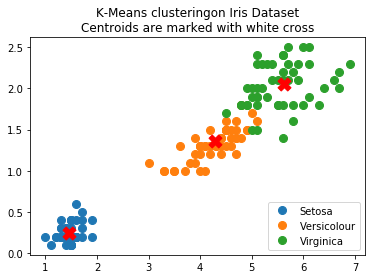

In [47]:
# 将K_means聚类之后的结果进行可视化展示出来
reduced_data=x
reduced_centers=means
# 设置图例
symbols=['o']
label_name=['Setosa','Versicolour','Virginica']
for i in range(3):
    temp_group=reduced_data[(i*50):(50)*(i+1)]
    plt.plot(temp_group[:,0], temp_group[:,1], symbols[0], markersize=8, label=label_name[i])
    
# 绘图
plt.scatter(reduced_centers[:,0].asnumpy(), reduced_centers[:,1].asnumpy(),
            marker='X', s=169, linewidths=1, color='red', zorder=10)
plt.title('K-Means clusteringon Iris Dataset\n'
         'Centroids are marked with white cross')
plt.legend(loc='lower right')
plt.show()